T-SNE 플롯 찍기용

In [1]:
# 사전 변수
checkpoint_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_poisson_2024-12-27-13-02-25_fold1_lastEpoch.pt"
config_json_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_poisson_2024-12-27-13-02-25_fold1_config.json"

savefile_name = "T-SNE_poisson.svg"



In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-01-19 22:01:52.908756: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 22:01:52.961193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 22:01:53.723205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# 환경설정
with open(config_json_dir, 'r') as f:
    print("config.json파일 읽기 성공!")
    json_data = json.load(f)

cuda_gpu = json_data['cuda_gpu']
model_name = json_data['model_name']
num_classes = json_data['num_classes']
num_encoders = json_data['num_encoders'] # 편의상 이녀석을 MIT-BIH 길이인 187로 지정하도록 한다.
early_stop = json_data['early_stop']
early_stop_enable = json_data['early_stop_enable']
learning_rate = json_data['init_lr']
batch_size = json_data['batch_size']
num_epochs = json_data['num_epochs']
train_path = json_data['train_path']
test_path = json_data['test_path']
class_weight = json_data['class_weight']
encoder_min = json_data['encoder_min']
encoder_max = json_data['encoder_max']
hidden_size = json_data['hidden_size']
hidden_size_2 = json_data['hidden_size_2']
scheduler_tmax = json_data['scheduler_tmax']
scheduler_eta_min = json_data['scheduler_eta_min']
encoder_requires_grad = json_data['encoder_requires_grad']
timestep = json_data['timestep']
random_seed = json_data['random_seed']
checkpoint_save = json_data['checkpoint_save']
checkpoint_path = json_data['checkpoint_path']
threshold_value = json_data['threshold_value']
reset_value_residual = json_data['reset_value_residual']
need_bias = json_data['need_bias']
k_folds = json_data['k_folds']

# Cuda 써야겠지?
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_gpu)  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용
# input() # 일시정지용

# 랜덤시드 고정
seed = random_seed
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
    


# 데이터 가져오는 알맹이 클래스
class MITLoader_MLP_binary(Dataset):

    def __init__(self, csv_file, transforms: Callable = lambda x: x) -> None:
        super().__init__()
        self.annotations = pd.read_csv(csv_file).values
        self.transforms = transforms

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, item):
        signal = self.annotations[item, :-1]
        signal = torch.from_numpy(signal).float()
        if self.transforms : 
            signal = self.transforms(signal)
        
        label = int(self.annotations[item, -1])
        if label > 0:
            label = 1  # 1 이상인 모든 값은 1로 변환(난 이진값 처리하니깐)

        return signal, torch.tensor(label).long()
    

config.json파일 읽기 성공!
Device :cuda


torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size([256, 187])
torch.Size(

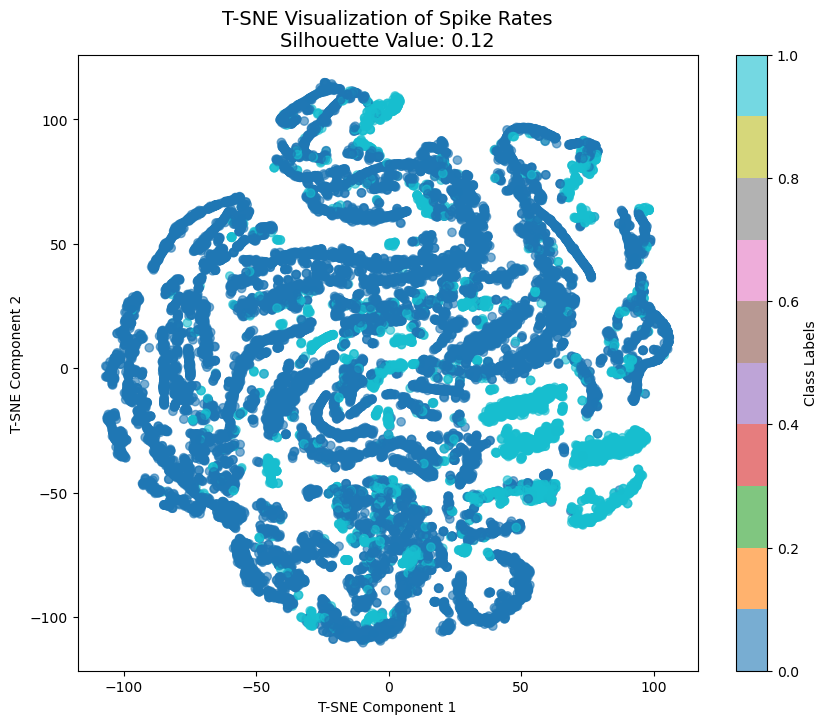

In [4]:
# 모델 로드 함수 정의
def load_model(checkpoint_path_, model):
    checkpoint = torch.load(checkpoint_path_)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 평가 모드로 전환
    return model

# Spike rate 계산 함수 정의
def compute_spike_rate(encoder, data_loader):
    spike_rates = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            # Spike sum 초기화 (encoded_data 크기 기반)
            encoded_data = encoder(data)  # 한 번의 포아송 인코딩
            spike_sum = torch.zeros_like(encoded_data)  # 동일한 크기로 초기화

            # poisson 인코더 통과
            for i in range(timestep):
                encoded_data = encoder(data)
                spike_sum += encoded_data
            # Spike rate 계산 (스파이크 총합 / 필터 크기)
            spike_rate = spike_sum / timestep
            print(spike_rate.shape)
            spike_rates.append(spike_rate.cpu().numpy())
            labels.append(target.cpu().numpy())

    spike_rates = np.concatenate(spike_rates, axis=0)
    labels = np.concatenate(labels, axis=0)
    return spike_rates, labels

# T-SNE 시각화 함수 정의(알파 블렌딩 및 Silhouette Value 추가)
def plot_tsne_with_silhouette(spike_rates, labels):
    # T-SNE 변환 수행
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(spike_rates)

    # Silhouette Value 계산
    silhouette_val = silhouette_score(spike_rates, labels)

    # 그래프 생성
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        tsne_results[:, 0], tsne_results[:, 1], 
        c=labels, cmap='tab10', alpha=0.6  # 알파 블렌딩 적용
    )

    # 컬러바 추가
    plt.colorbar(scatter, label='Class Labels')

    # 그래프 제목과 라벨 설정
    plt.title(f'T-SNE Visualization of Spike Rates\nSilhouette Value: {silhouette_val:.2f}', fontsize=14)
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')

    # 그래프 저장
    plt.savefig(savefile_name, format="svg", bbox_inches="tight")

    # 그래프 표시
    plt.show()

# 모델, 로더, 인코더 지정
dataset = MITLoader_MLP_binary(csv_file=test_path)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)
poisson_encoder = encoding.PoissonEncoder()

# 스파이크 레이트 계산
spike_rates, labels = compute_spike_rate(poisson_encoder, data_loader)

# T-SNE 시각화 및 Silhouette Value 출력
print("인코딩 완료, 시각화 및 Silhouette Value 계산 중...")
plot_tsne_with_silhouette(spike_rates, labels)


In [5]:
# 실루엣값만 따로 보기
silhouette_val = silhouette_score(spike_rates, labels)
print(silhouette_val)

0.1153884
